In [1]:
# imports 
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from pathlib import Path
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
import warnings
import pingouin as pg
from sklearn.linear_model import LinearRegression
import glob
import os
import h5_utilities_module as h5u

In [2]:
#functions
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval

def normalize_data(data, axis=None):
    """
    Normalize the input data to the range [0, 1].

    Parameters:
    - data: numpy array, the data to be normalized.
    - axis: int, list of ints, or 'all', the axis or axes along which to normalize. 
            If 'all', the entire array is normalized.

    Returns:
    - normalized_data: numpy array, the normalized data.
    """
    data = np.asarray(data)  # Ensure data is a numpy array
    
    if axis == 'all':
        min_val = np.min(data)
        max_val = np.max(data)
        normalized_data = (data - min_val) / (max_val - min_val)
    
    elif axis is not None:
        min_val = np.min(data, axis=axis, keepdims=True)
        max_val = np.max(data, axis=axis, keepdims=True)
        normalized_data = (data - min_val) / (max_val - min_val)
    
    else:
        min_val = np.min(data)
        max_val = np.max(data)
        normalized_data = (data - min_val) / (max_val - min_val)
    
    return normalized_data

In [3]:
# where are the data?
data_dir = '/Users/thomaselston/Documents/PYTHON/self_control/single_neuron_summary/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)

In [4]:
h5u.list_hdf5_data(data_files[0])

Datasets in '/Users/thomaselston/Documents/PYTHON/self_control/single_neuron_summary/D20231224_Rec07_summary.h5':
brain_area
sacc1_fixwin_betas
sacc1_fixwin_pvals
sacc1_val_betas
sacc1_val_pvals
sacc_offset_t
shuffle_auc_scores
state_auc_scores
t_factor_pvals
ts
valstate_betas
valstate_pvals


In [5]:
# initialize lists to accumulate data into
brain_area = []
sacc1_fixwin_betas = []
sacc1_fixwin_pvals = []
sacc1_val_betas = []
sacc1_val_pvals = []
state_auc_scores = []
shuffle_auc_scores = []
valstate_betas = []
valstate_pvals = []
t_factor_pvals = []
subject = []

# accumulate data from each file

for this_file in data_files:
    
    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1
            
    # Append the data to the lists
    
    brain_area.append(h5u.pull_from_h5(this_file, 'brain_area'))
    subject.append(np.ones(len(h5u.pull_from_h5(this_file, 'brain_area')), )*s)
    sacc1_fixwin_betas.append(h5u.pull_from_h5(this_file, 'sacc1_fixwin_betas'))
    sacc1_fixwin_pvals.append(h5u.pull_from_h5(this_file, 'sacc1_fixwin_pvals'))
    sacc1_val_betas.append(h5u.pull_from_h5(this_file, 'sacc1_val_betas'))
    sacc1_val_pvals.append(h5u.pull_from_h5(this_file, 'sacc1_val_pvals'))
    state_auc_scores.append(h5u.pull_from_h5(this_file, 'state_auc_scores'))
    shuffle_auc_scores.append(h5u.pull_from_h5(this_file, 'shuffle_auc_scores'))
    t_factor_pvals.append(h5u.pull_from_h5(this_file, 't_factor_pvals'))
    valstate_betas.append(h5u.pull_from_h5(this_file, 'valstate_betas'))
    valstate_pvals.append(h5u.pull_from_h5(this_file, 'valstate_pvals'))

ts = h5u.pull_from_h5(this_file, 'ts')
sacc_offset = h5u.pull_from_h5(this_file, 'sacc_offset_t')

# convert everything back to arrays
brain_area = np.concatenate(brain_area, axis=0)
subject = np.concatenate(subject, axis=0)
sacc1_fixwin_betas = np.concatenate(sacc1_fixwin_betas, axis=0)
sacc1_fixwin_pvals = np.concatenate(sacc1_fixwin_pvals, axis=0)
sacc1_val_betas = np.concatenate(sacc1_val_betas, axis=0)
sacc1_val_pvals = np.concatenate(sacc1_val_pvals, axis=0)
state_auc_scores = np.concatenate(state_auc_scores, axis=0)
shuffle_auc_scores = np.concatenate(shuffle_auc_scores, axis=0)
t_factor_pvals = np.concatenate(t_factor_pvals, axis=0)
valstate_betas = np.concatenate(valstate_betas, axis=0)
valstate_pvals = np.concatenate(valstate_pvals, axis=0)

(0.0, 60.0)

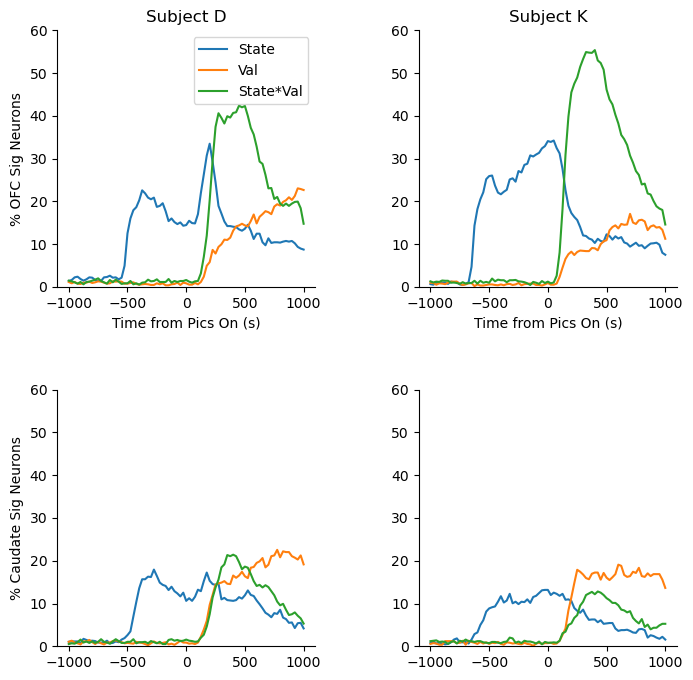

In [6]:
ofc_ix = brain_area == 1
cdn_ix = brain_area == 0
d_ix = subject == 0
k_ix = subject == 1


# pull out the factors
pure_state_ix = t_factor_pvals[: , :, 0] < .01
pure_val_ix = t_factor_pvals[: , :, 1] < .01
pure_cue_ix = t_factor_pvals[: , :, 2] < .01
state_val_ix = t_factor_pvals[: , :, 3] < .01
state_cue_ix = t_factor_pvals[: , :, 4] < .01

ylims = (0, 60)

# set up some exclusive indices of the factors 
# - ensure that the approach of one inclusion and one exclusion criterion is universally applied
state_coding = pure_state_ix & ~state_cue_ix & ~state_val_ix
val_coding = pure_val_ix & ~state_val_ix & ~pure_state_ix
state_val_coding = state_val_ix & ~state_coding & ~val_coding


fig, prop_ax = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

prop_ax[0,0].plot(ts, np.mean(state_coding[ofc_ix & d_ix, :], axis=0) * 100, label='State')
prop_ax[0,0].plot(ts, np.mean(val_coding[ofc_ix & d_ix, :], axis=0) * 100, label='Val')
prop_ax[0,0].plot(ts, np.mean(state_val_coding[ofc_ix & d_ix, :], axis=0) * 100, label='State*Val')
prop_ax[0,0].spines['top'].set_visible(False)
prop_ax[0,0].spines['right'].set_visible(False)
prop_ax[0,0].set_xlabel('Time from Pics On (s)')
prop_ax[0,0].set_ylabel('% OFC Sig Neurons')
prop_ax[0,0].set_title('Subject D')
prop_ax[0,0].set_ylim(ylims)
prop_ax[0,0].legend()


prop_ax[1,0].plot(ts, np.mean(state_coding[cdn_ix & d_ix, :], axis=0) * 100)
prop_ax[1,0].plot(ts, np.mean(val_coding[cdn_ix & d_ix, :], axis=0) * 100)
prop_ax[1,0].plot(ts, np.mean(state_val_coding[cdn_ix & d_ix, :], axis=0) * 100)
prop_ax[1,0].spines['top'].set_visible(False)
prop_ax[1,0].spines['right'].set_visible(False)
prop_ax[1,0].set_ylim(ylims)
prop_ax[1,0].set_ylabel('% Caudate Sig Neurons')

prop_ax[0,1].plot(ts, np.mean(state_coding[ofc_ix & k_ix, :], axis=0) * 100, label='State')
prop_ax[0,1].plot(ts, np.mean(val_coding[ofc_ix & k_ix, :], axis=0) * 100, label='Val')
prop_ax[0,1].plot(ts, np.mean(state_val_coding[ofc_ix & k_ix, :], axis=0) * 100, label='State*Val')
prop_ax[0,1].spines['top'].set_visible(False)
prop_ax[0,1].spines['right'].set_visible(False)
prop_ax[0,1].set_ylim(ylims)
prop_ax[0,1].set_xlabel('Time from Pics On (s)')
prop_ax[0,1].set_title('Subject K')


prop_ax[1,1].plot(ts, np.mean(state_coding[cdn_ix & k_ix, :], axis=0) * 100)
prop_ax[1,1].plot(ts, np.mean(val_coding[cdn_ix & k_ix, :], axis=0) * 100)
prop_ax[1,1].plot(ts, np.mean(state_val_coding[cdn_ix & k_ix, :], axis=0) * 100)
prop_ax[1,1].spines['top'].set_visible(False)
prop_ax[1,1].spines['right'].set_visible(False)
prop_ax[1,1].set_ylim(ylims)

#plt.savefig("prop_sig_neurons.svg")





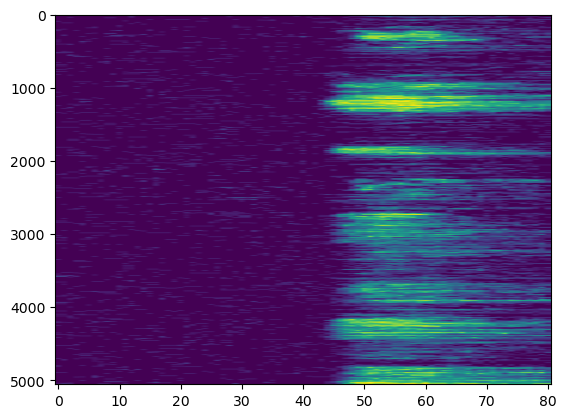

In [16]:
plt.imshow(state_val_coding, aspect='auto')

(array([0.00037471, 0.00046838, 0.00018735, 0.00056206, 0.00131148,
        0.00159251, 0.00290398, 0.00327869, 0.00449649, 0.00487119,
        0.00309133, 0.00421546, 0.00309133, 0.00299766, 0.00215457,
        0.00140515, 0.00112412, 0.00140515, 0.00046838]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.,
        275., 300., 325., 350., 375., 400., 425., 450., 475.]),
 <BarContainer object of 19 artists>)

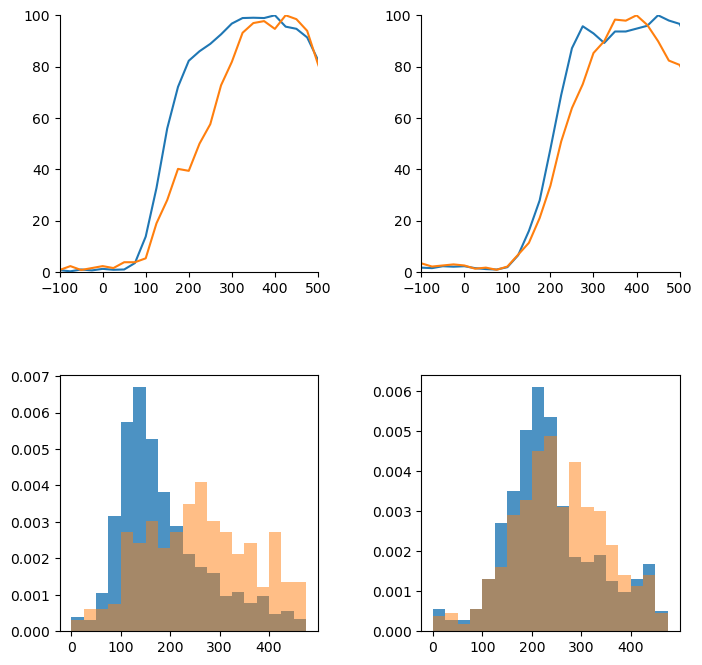

In [59]:
fig, prop_ax2 = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

state_val_ix = np.sum(state_val_coding[:, 45:61], axis=1) >= 2 # there must be at least two significant time bins

bins = np.arange(0*np.mean(np.diff(ts)), 20*np.mean(np.diff(ts)), np.mean(np.diff(ts)))

# to make the time effect pop, let's normalize to between zero and one
k_ofc_state_val = np.mean(state_val_coding[ofc_ix & k_ix & state_val_ix, :], axis=0)
k_cdn_state_val = np.mean(state_val_coding[cdn_ix & k_ix & state_val_ix, :], axis=0)

d_ofc_state_val = np.mean(state_val_coding[ofc_ix & d_ix & state_val_ix, :], axis=0)
d_cdn_state_val = np.mean(state_val_coding[cdn_ix & d_ix & state_val_ix, :], axis=0)

k_ofc_state_val_nrml = normalize_data(k_ofc_state_val)
k_cdn_state_val_nrml = normalize_data(k_cdn_state_val)
d_ofc_state_val_nrml = normalize_data(d_ofc_state_val)
d_cdn_state_val_nrml = normalize_data(d_cdn_state_val)

# look at latencies
k_ofc_valstate_latencies = np.argmax(state_val_coding[ofc_ix & k_ix & state_val_ix, 41:61], axis=1)
k_cdn_valstate_latencies = np.argmax(state_val_coding[cdn_ix & k_ix & state_val_ix, 41:61], axis=1)
d_ofc_valstate_latencies = np.argmax(state_val_coding[ofc_ix & d_ix & state_val_ix, 41:61], axis=1)
d_cdn_valstate_latencies = np.argmax(state_val_coding[cdn_ix & d_ix & state_val_ix, 41:61], axis=1)


prop_ax2[0,0].plot(ts, k_ofc_state_val_nrml * 100)
prop_ax2[0,0].plot(ts, k_cdn_state_val_nrml* 100)
prop_ax2[0,0].spines['top'].set_visible(False)
prop_ax2[0,0].spines['right'].set_visible(False)
prop_ax2[0,0].set_xlim((-100, 500))
prop_ax2[0,0].set_ylim((0, 100))

prop_ax2[1,0].hist(k_ofc_valstate_latencies*np.mean(np.diff(ts)), bins=bins, density='probability', alpha=.8)
prop_ax2[1,0].hist(k_cdn_valstate_latencies*np.mean(np.diff(ts)), bins=bins, density ='probability', alpha = .5)


prop_ax2[0,1].plot(ts, d_ofc_state_val_nrml * 100)
prop_ax2[0,1].plot(ts, d_cdn_state_val_nrml * 100)
prop_ax2[0,1].spines['top'].set_visible(False)
prop_ax2[0,1].spines['right'].set_visible(False)
prop_ax2[0,1].set_xlim((-100, 500))
prop_ax2[0,1].set_ylim((0, 100))

prop_ax2[1,1].hist(d_ofc_valstate_latencies*np.mean(np.diff(ts)), bins=bins, density='probability', alpha=.8)
prop_ax2[1,1].hist(d_cdn_valstate_latencies*np.mean(np.diff(ts)), bins=bins, density ='probability', alpha = .5)


#plt.savefig("OFC leads CdN v2.svg")

In [63]:
pg.ttest(k_ofc_valstate_latencies, k_cdn_valstate_latencies, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-10.911921,1413,two-sided,1.132552e-26,"[-3.35, -2.33]",0.744629,2.547e+23,1.0


In [ ]:
# compute mean and confidence intervals for the real data
state_moments = pure_state_ix
state_units = np.sum(state_moments[:, 20:30], axis=1) > 6

fig, auc_ax = plt.subplots(2, 4, figsize=(12, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

# SUBJECT K
# OFC
k_state1_mean, k_state1_ci =  calculate_mean_and_interval(state_auc_scores[ofc_ix & state_units & k_ix, :, 0], type='bootstrap', num_samples=1000, alpha=0.01)
k_state2_mean, k_state2_ci =  calculate_mean_and_interval(state_auc_scores[ofc_ix & state_units & k_ix, :, 1], type='bootstrap', num_samples=1000, alpha=0.01)
k_state3_mean, k_state3_ci =  calculate_mean_and_interval(state_auc_scores[ofc_ix & state_units & k_ix, :, 2], type='bootstrap', num_samples=1000, alpha=0.01)
k_state1vs2_mean, k_state1vs2_ci =  calculate_mean_and_interval(state_auc_scores[ofc_ix & state_units & k_ix, :, 3], type='bootstrap', num_samples=1000, alpha=0.01)

# compute mean and confidence intervals for the shuffled data
ks_state1_mean, ks_state1_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix & state_units & k_ix, :, 0], type='percentile', num_samples=1000, alpha=0.01)
ks_state2_mean, ks_state2_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix & state_units & k_ix, :, 1], type='percentile', num_samples=1000, alpha=0.01)
ks_state3_mean, ks_state3_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix & state_units & k_ix, :, 2], type='percentile', num_samples=1000, alpha=0.01)
ks_state1vs2_mean, ks_state1vs2_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix & state_units & k_ix, :, 3], type='percentile', num_samples=1000, alpha=0.01)

# OFC

# plot the 1-vs-all scores
auc_ax[0,0].plot(ts, k_state1_mean, color='tab:red', label='State A')
auc_ax[0,0].fill_between(ts, k_state1_mean - k_state1_ci, k_state1_mean + k_state1_ci, color='tab:red', alpha = .5)
auc_ax[0,0].plot(ts, k_state2_mean, color='tab:blue', label='State B')
auc_ax[0,0].fill_between(ts, k_state2_mean - k_state2_ci, k_state2_mean + k_state2_ci, color='tab:blue', alpha = .5)
auc_ax[0,0].plot(ts, k_state3_mean, color='tab:green', label='State C')
auc_ax[0,0].fill_between(ts, k_state3_mean - k_state3_ci, k_state3_mean + k_state3_ci, color='tab:green', alpha = .5)

auc_ax[0,0].plot(ts, ks_state1_mean, color='tab:red')
auc_ax[0,0].fill_between(ts, ks_state1_mean - ks_state1_ci, ks_state1_mean + ks_state1_ci, color='tab:red', alpha = .3)
auc_ax[0,0].plot(ts, ks_state2_mean, color='tab:blue')
auc_ax[0,0].fill_between(ts, ks_state2_mean - ks_state2_ci, ks_state2_mean + ks_state2_ci, color='tab:blue', alpha = .3)
auc_ax[0,0].plot(ts, ks_state3_mean, color='tab:green')
auc_ax[0,0].fill_between(ts, ks_state3_mean - ks_state3_ci, ks_state3_mean + ks_state3_ci, color='tab:green', alpha = .3)
auc_ax[0,0].spines['top'].set_visible(False)
auc_ax[0,0].spines['right'].set_visible(False)
auc_ax[0,0].set_ylim((.5, .65))
auc_ax[0,0].set_xlim((-1000, 1000))
auc_ax[0,0].set_ylabel('OFC Rectified AUC')
auc_ax[0,0].set_xlabel('Time from Pics On (s)')
auc_ax[0,0].set_title('One vs All AUC Scores')
auc_ax[0,0].legend()


# plot the state 1 vs state 2 scores
auc_ax[0,1].plot(ts, k_state1vs2_mean, color='tab:purple', label='State A vs B')
auc_ax[0,1].fill_between(ts, k_state1vs2_mean - k_state1vs2_ci, k_state1vs2_mean + k_state1vs2_ci, color='tab:purple', alpha = .5)
auc_ax[0,1].plot(ts, ks_state1vs2_mean, color='tab:gray')
auc_ax[0,1].fill_between(ts, ks_state1vs2_mean - ks_state1vs2_ci, ks_state1vs2_mean + ks_state1vs2_ci, color='tab:gray', alpha = .5)
auc_ax[0,1].spines['top'].set_visible(False)
auc_ax[0,1].spines['right'].set_visible(False)
auc_ax[0,1].set_ylim((.5, .65))
auc_ax[0,1].set_xlim((-1000, 1000))
auc_ax[0,1].set_title('State A vs State B')

# CAUDATE
state1_mean, state1_ci =  calculate_mean_and_interval(state_auc_scores[cdn_ix & state_units & k_ix, :, 0], type='bootstrap', num_samples=1000, alpha=0.01)
state2_mean, state2_ci =  calculate_mean_and_interval(state_auc_scores[cdn_ix & state_units & k_ix, :, 1], type='bootstrap', num_samples=1000, alpha=0.01)
state3_mean, state3_ci =  calculate_mean_and_interval(state_auc_scores[cdn_ix & state_units & k_ix, :, 2], type='bootstrap', num_samples=1000, alpha=0.01)
state1vs2_mean, state1vs2_ci =  calculate_mean_and_interval(state_auc_scores[cdn_ix & state_units & k_ix, :, 3], type='bootstrap', num_samples=1000, alpha=0.01)

# compute mean and confidence intervals for the shuffled data
s_state1_mean, s_state1_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix & state_units & k_ix, :, 0], type='percentile', num_samples=1000, alpha=0.01)
s_state2_mean, s_state2_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix & state_units & k_ix, :, 1], type='percentile', num_samples=1000, alpha=0.01)
s_state3_mean, s_state3_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix & state_units & k_ix, :, 2], type='percentile', num_samples=1000, alpha=0.01)
s_state1vs2_mean, s_state1vs2_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix & state_units & k_ix, :, 3], type='percentile', num_samples=1000, alpha=0.01)

# plot the 1-vs-all scores
auc_ax[1,0].plot(ts, state1_mean, color='tab:red', label='State A')
auc_ax[1,0].fill_between(ts, state1_mean - state1_ci, state1_mean + state1_ci, color='tab:red', alpha = .5)
auc_ax[1,0].plot(ts, state2_mean, color='tab:blue', label='State B')
auc_ax[1,0].fill_between(ts, state2_mean - state2_ci, state2_mean + state2_ci, color='tab:blue', alpha = .5)
auc_ax[1,0].plot(ts, state3_mean, color='tab:green', label='State C')
auc_ax[1,0].fill_between(ts, state3_mean - state3_ci, state3_mean + state3_ci, color='tab:green', alpha = .5)

auc_ax[1,0].plot(ts, s_state1_mean, color='tab:red')
auc_ax[1,0].fill_between(ts, s_state1_mean - s_state1_ci, s_state1_mean + s_state1_ci, color='tab:red', alpha = .3)
auc_ax[1,0].plot(ts, s_state2_mean, color='tab:blue')
auc_ax[1,0].fill_between(ts, s_state2_mean - s_state2_ci, s_state2_mean + s_state2_ci, color='tab:blue', alpha = .3)
auc_ax[1,0].plot(ts, s_state3_mean, color='tab:green')
auc_ax[1,0].fill_between(ts, s_state3_mean - s_state3_ci, s_state3_mean + s_state3_ci, color='tab:green', alpha = .3)
auc_ax[1,0].spines['top'].set_visible(False)
auc_ax[1,0].spines['right'].set_visible(False)
auc_ax[1,0].set_ylim((.5, .65))
auc_ax[1,0].set_xlim((-1000, 1000))
auc_ax[1,0].set_ylabel('CdN Rectified AUC')
auc_ax[1,0].set_xlabel('Time from Pics On (s)')

# plot the state 1 vs state 2 scores
auc_ax[1,1].plot(ts, state1vs2_mean, color='tab:purple', label='State A vs B')
auc_ax[1,1].fill_between(ts, state1vs2_mean - state1vs2_ci, state1vs2_mean + state1vs2_ci, color='tab:purple', alpha = .5)
auc_ax[1,1].plot(ts, s_state1vs2_mean, color='tab:gray')
auc_ax[1,1].fill_between(ts, s_state1vs2_mean - s_state1vs2_ci, s_state1vs2_mean + s_state1vs2_ci, color='tab:gray', alpha = .5)
auc_ax[1,1].spines['top'].set_visible(False)
auc_ax[1,1].spines['right'].set_visible(False)
auc_ax[1,1].set_ylim((.5, .65))
auc_ax[1,1].set_xlim((-1000, 1000))

# SUBJECT D
# OFC
d_state1_mean, d_state1_ci =  calculate_mean_and_interval(state_auc_scores[ofc_ix & state_units & d_ix, :, 0], type='bootstrap', num_samples=1000, alpha=0.01)
d_state2_mean, d_state2_ci =  calculate_mean_and_interval(state_auc_scores[ofc_ix & state_units & d_ix, :, 1], type='bootstrap', num_samples=1000, alpha=0.01)
d_state3_mean, d_state3_ci =  calculate_mean_and_interval(state_auc_scores[ofc_ix & state_units & d_ix, :, 2], type='bootstrap', num_samples=1000, alpha=0.01)
d_state1vs2_mean, d_state1vs2_ci =  calculate_mean_and_interval(state_auc_scores[ofc_ix & state_units & d_ix, :, 3], type='bootstrap', num_samples=1000, alpha=0.01)

# compute mean and confidence intervals for the shuffled data
ds_state1_mean, ds_state1_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix & state_units & d_ix, :, 0], type='percentile', num_samples=1000, alpha=0.01)
ds_state2_mean, ds_state2_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix & state_units & d_ix, :, 1], type='percentile', num_samples=1000, alpha=0.01)
ds_state3_mean, ds_state3_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix & state_units & d_ix, :, 2], type='percentile', num_samples=1000, alpha=0.01)
ds_state1vs2_mean, ds_state1vs2_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix & state_units & d_ix, :, 3], type='percentile', num_samples=1000, alpha=0.01)

# OFC

# plot the 1-vs-all scores
auc_ax[0,2].plot(ts, d_state1_mean, color='tab:red', label='State A')
auc_ax[0,2].fill_between(ts, d_state1_mean - d_state1_ci, d_state1_mean + d_state1_ci, color='tab:red', alpha = .5)
auc_ax[0,2].plot(ts, d_state2_mean, color='tab:blue', label='State B')
auc_ax[0,2].fill_between(ts, d_state2_mean - d_state2_ci, d_state2_mean + d_state2_ci, color='tab:blue', alpha = .5)
auc_ax[0,2].plot(ts, d_state3_mean, color='tab:green', label='State C')
auc_ax[0,2].fill_between(ts, d_state3_mean - d_state3_ci, d_state3_mean + d_state3_ci, color='tab:green', alpha = .5)

auc_ax[0,2].plot(ts, ds_state1_mean, color='tab:red')
auc_ax[0,2].fill_between(ts, ds_state1_mean - ds_state1_ci, ds_state1_mean + ds_state1_ci, color='tab:red', alpha = .3)
auc_ax[0,2].plot(ts, ds_state2_mean, color='tab:blue')
auc_ax[0,2].fill_between(ts, ds_state2_mean - ds_state2_ci, ds_state2_mean + ds_state2_ci, color='tab:blue', alpha = .3)
auc_ax[0,2].plot(ts, ds_state3_mean, color='tab:green')
auc_ax[0,2].fill_between(ts, ds_state3_mean - ds_state3_ci, ds_state3_mean + ds_state3_ci, color='tab:green', alpha = .3)
auc_ax[0,2].spines['top'].set_visible(False)
auc_ax[0,2].spines['right'].set_visible(False)
auc_ax[0,2].set_ylim((.5, .65))
auc_ax[0,2].set_xlim((-1000, 1000))
auc_ax[0,2].set_ylabel('OFC Rectified AUC')
auc_ax[0,2].set_xlabel('Time from Pics On (s)')
auc_ax[0,2].set_title('One vs All AUC Scores')
auc_ax[0,2].legend()


# plot the state 1 vs state 2 scores
auc_ax[0,3].plot(ts, d_state1vs2_mean, color='tab:purple', label='State A vs B')
auc_ax[0,3].fill_between(ts, d_state1vs2_mean - d_state1vs2_ci, d_state1vs2_mean + d_state1vs2_ci, color='tab:purple', alpha = .5)
auc_ax[0,3].plot(ts, ds_state1vs2_mean, color='tab:gray')
auc_ax[0,3].fill_between(ts, ds_state1vs2_mean - ds_state1vs2_ci, ds_state1vs2_mean + ds_state1vs2_ci, color='tab:gray', alpha = .5)
auc_ax[0,3].spines['top'].set_visible(False)
auc_ax[0,3].spines['right'].set_visible(False)
auc_ax[0,3].set_ylim((.5, .65))
auc_ax[0,3].set_xlim((-1000, 1000))
auc_ax[0,3].set_title('State A vs State B')

# CAUDATE
state1_mean, state1_ci =  calculate_mean_and_interval(state_auc_scores[cdn_ix & state_units & d_ix, :, 0], type='bootstrap', num_samples=1000, alpha=0.01)
state2_mean, state2_ci =  calculate_mean_and_interval(state_auc_scores[cdn_ix & state_units & d_ix, :, 1], type='bootstrap', num_samples=1000, alpha=0.01)
state3_mean, state3_ci =  calculate_mean_and_interval(state_auc_scores[cdn_ix & state_units & d_ix, :, 2], type='bootstrap', num_samples=1000, alpha=0.01)
state1vs2_mean, state1vs2_ci =  calculate_mean_and_interval(state_auc_scores[cdn_ix & state_units & d_ix, :, 3], type='bootstrap', num_samples=1000, alpha=0.01)

# compute mean and confidence intervals for the shuffled data
s_state1_mean, s_state1_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix & state_units & d_ix, :, 0], type='percentile', num_samples=1000, alpha=0.01)
s_state2_mean, s_state2_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix & state_units & d_ix, :, 1], type='percentile', num_samples=1000, alpha=0.01)
s_state3_mean, s_state3_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix & state_units & d_ix, :, 2], type='percentile', num_samples=1000, alpha=0.01)
s_state1vs2_mean, s_state1vs2_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix & state_units & d_ix, :, 3], type='percentile', num_samples=1000, alpha=0.01)

# plot the 1-vs-all scores
auc_ax[1,2].plot(ts, state1_mean, color='tab:red', label='State A')
auc_ax[1,2].fill_between(ts, state1_mean - state1_ci, state1_mean + state1_ci, color='tab:red', alpha = .5)
auc_ax[1,2].plot(ts, state2_mean, color='tab:blue', label='State B')
auc_ax[1,2].fill_between(ts, state2_mean - state2_ci, state2_mean + state2_ci, color='tab:blue', alpha = .5)
auc_ax[1,2].plot(ts, state3_mean, color='tab:green', label='State C')
auc_ax[1,2].fill_between(ts, state3_mean - state3_ci, state3_mean + state3_ci, color='tab:green', alpha = .5)

auc_ax[1,2].plot(ts, s_state1_mean, color='tab:red')
auc_ax[1,2].fill_between(ts, s_state1_mean - s_state1_ci, s_state1_mean + s_state1_ci, color='tab:red', alpha = .3)
auc_ax[1,2].plot(ts, s_state2_mean, color='tab:blue')
auc_ax[1,2].fill_between(ts, s_state2_mean - s_state2_ci, s_state2_mean + s_state2_ci, color='tab:blue', alpha = .3)
auc_ax[1,2].plot(ts, s_state3_mean, color='tab:green')
auc_ax[1,2].fill_between(ts, s_state3_mean - s_state3_ci, s_state3_mean + s_state3_ci, color='tab:green', alpha = .3)
auc_ax[1,2].spines['top'].set_visible(False)
auc_ax[1,2].spines['right'].set_visible(False)
auc_ax[1,2].set_ylim((.5, .65))
auc_ax[1,2].set_xlim((-1000, 1000))
auc_ax[1,2].set_ylabel('CdN Rectified AUC')
auc_ax[1,2].set_xlabel('Time from Pics On (s)')

# plot the state 1 vs state 2 scores
auc_ax[1,3].plot(ts, state1vs2_mean, color='tab:purple', label='State A vs B')
auc_ax[1,3].fill_between(ts, state1vs2_mean - state1vs2_ci, state1vs2_mean + state1vs2_ci, color='tab:purple', alpha = .5)
auc_ax[1,3].plot(ts, s_state1vs2_mean, color='tab:gray')
auc_ax[1,3].fill_between(ts, s_state1vs2_mean - s_state1vs2_ci, s_state1vs2_mean + s_state1vs2_ci, color='tab:gray', alpha = .5)
auc_ax[1,3].spines['top'].set_visible(False)
auc_ax[1,3].spines['right'].set_visible(False)
auc_ax[1,3].set_ylim((.5, .65))
auc_ax[1,3].set_xlim((-1000, 1000))

In [ ]:
# subject K!

fig, ax = plt.subplots(2, 3, figsize=(9, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

ylims = (0, .4)

state_colors = ['tab:red', 'tab:blue', 'tab:green']

states = [0,1,2]
state_names = ['A', 'B', 'C']

for sel_state in range(3):
    
    if sel_state == 0:
        # Find the neurons selective in this state via the single-saccade trials
        sel_ix = (sacc1_fixwin_pvals[:, 0] < .01) & (np.argmax(np.abs(sacc1_fixwin_betas), axis=1) ==0)

    elif sel_state == 1:
        # Add conditions for sel_state == 1
        sel_ix = (sacc1_fixwin_pvals[:, 1] < .01) & (np.argmax(np.abs(sacc1_fixwin_betas), axis=1) ==1)

    elif sel_state == 2:
        # Add conditions for sel_state == 2
        sel_ix = (sacc1_fixwin_pvals[:, 2] < .01) & (np.argmax(np.abs(sacc1_fixwin_betas), axis=1) ==2)


    # now look at the value-coding in each of the states - the diagonal will be the ground-truth
    for i_state in range(3):
        
        # get the mean and confidence intervals
        ofc_mean, ofc_ci = calculate_mean_and_interval(np.abs(sacc1_val_betas[ofc_ix & sel_ix & k_ix,:, i_state]), 'bootstrap')
        cdn_mean, cdn_ci = calculate_mean_and_interval(np.abs(sacc1_val_betas[cdn_ix & sel_ix & k_ix,:, i_state]), 'bootstrap')
        
        ax[0, sel_state].plot(sacc_offset, ofc_mean, color=state_colors[i_state], label = state_names[i_state])
        ax[0, sel_state].fill_between(sacc_offset, ofc_mean - ofc_ci, ofc_mean+ofc_ci, color=state_colors[i_state], alpha = .5)
        
        ax[1, sel_state].plot(sacc_offset, cdn_mean, color=state_colors[i_state], label = state_names[i_state])
        ax[1, sel_state].fill_between(sacc_offset, cdn_mean - cdn_ci, cdn_mean+cdn_ci, color=state_colors[i_state], alpha = .5)
        
        
    ax[0, sel_state].set_title(f'State {state_names[sel_state]}')
    ax[0, sel_state].spines['top'].set_visible(False)
    ax[0, sel_state].spines['right'].set_visible(False)
    ax[0, sel_state].set_ylim(ylims)
    ax[0, sel_state].set_xticks((-400, -200, 0, 200, 400))
    ax[0, sel_state].set_xlim((-400, 400))
    
    ax[1, sel_state].spines['top'].set_visible(False)
    ax[1, sel_state].spines['right'].set_visible(False)
    ax[1, sel_state].set_ylim(ylims)
    ax[1, sel_state].set_xticks((-400, -200, 0, 200, 400))
    ax[1, sel_state].set_xlim((-400, 400))

    if sel_state ==0:
        ax[0, sel_state].set_ylabel(r'OFC abs($\beta$value)')
        ax[1, sel_state].set_ylabel(r'CdN abs($\beta$value)')
        ax[0, sel_state].set_xlabel('Time from Sacc (ms)')
        ax[0, sel_state].legend(loc='upper left')

#plt.savefig("StateDepValue.svg")
        

In [ ]:
# subject D!

fig, ax = plt.subplots(2, 3, figsize=(9, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

ylims = (0, .4)

state_colors = ['tab:red', 'tab:blue', 'tab:green']

states = [0,1,2]
state_names = ['A', 'B', 'C']

for sel_state in range(3):
    
    if sel_state == 0:
        # Find the neurons selective in this state via the single-saccade trials
        sel_ix = (sacc1_fixwin_pvals[:, 0] < .01) & (np.argmax(np.abs(sacc1_fixwin_betas), axis=1) ==0)

    elif sel_state == 1:
        # Add conditions for sel_state == 1
        sel_ix = (sacc1_fixwin_pvals[:, 1] < .01) & (np.argmax(np.abs(sacc1_fixwin_betas), axis=1) ==1)

    elif sel_state == 2:
        # Add conditions for sel_state == 2
        sel_ix = (sacc1_fixwin_pvals[:, 2] < .01) & (np.argmax(np.abs(sacc1_fixwin_betas), axis=1) ==2)


    # now look at the value-coding in each of the states - the diagonal will be the ground-truth
    for i_state in range(3):
        
        # get the mean and confidence intervals
        ofc_mean, ofc_ci = calculate_mean_and_interval(np.abs(sacc1_val_betas[ofc_ix & sel_ix & d_ix,:, i_state]), 'bootstrap')
        cdn_mean, cdn_ci = calculate_mean_and_interval(np.abs(sacc1_val_betas[cdn_ix & sel_ix & d_ix,:, i_state]), 'bootstrap')
        
        ax[0, sel_state].plot(sacc_offset, ofc_mean, color=state_colors[i_state], label = state_names[i_state])
        ax[0, sel_state].fill_between(sacc_offset, ofc_mean - ofc_ci, ofc_mean+ofc_ci, color=state_colors[i_state], alpha = .5)
        
        ax[1, sel_state].plot(sacc_offset, cdn_mean, color=state_colors[i_state], label = state_names[i_state])
        ax[1, sel_state].fill_between(sacc_offset, cdn_mean - cdn_ci, cdn_mean+cdn_ci, color=state_colors[i_state], alpha = .5)
        
        
    ax[0, sel_state].set_title(f'State {state_names[sel_state]}')
    ax[0, sel_state].spines['top'].set_visible(False)
    ax[0, sel_state].spines['right'].set_visible(False)
    ax[0, sel_state].set_ylim(ylims)
    ax[0, sel_state].set_xticks((-400, -200, 0, 200, 400))
    ax[0, sel_state].set_xlim((-400, 400))
    
    ax[1, sel_state].spines['top'].set_visible(False)
    ax[1, sel_state].spines['right'].set_visible(False)
    ax[1, sel_state].set_ylim(ylims)
    ax[1, sel_state].set_xticks((-400, -200, 0, 200, 400))
    ax[1, sel_state].set_xlim((-400, 400))

    if sel_state ==0:
        ax[0, sel_state].set_ylabel(r'OFC abs($\beta$value)')
        ax[1, sel_state].set_ylabel(r'CdN abs($\beta$value)')
        ax[0, sel_state].set_xlabel('Time from Sacc (ms)')
        ax[0, sel_state].legend(loc='upper left')


        